In [1]:
# imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import struct
from array import array
from os.path  import join
import random


# started from this video: https://www.youtube.com/watch?v=w8yWXqWQYmU&t=579s

In [2]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline

#
# Set file paths based on added MNIST Datasets
#
input_path = './MNIST_ORG/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# x_train and x_test are the images in a list of 28x28 arrays
# y_train and y_test are the number it should represent as a list of integers
# training data is 60000 labelled images, test is 10000 images

m = 60000
n = 784

l = 10000
# need to reshape the 28x28 arrays into one 784x1 array, since the input to the matrix multiplciation has to be a 1xn matrix, not nxn
x_train = np.array(x_train).reshape(m ,n).T / 255
x_test = np.array(x_test).reshape(l,n).T / 255
y_train = np.array(y_train).reshape(m)
y_test = np.array(y_test).reshape(l)

# x_train = x_train[,0:10000]
# y_train = y_train[0:10000,]

#
# Show some random training and test images
#
# images_2_show = []
# titles_2_show = []
# for i in range(0, 10):
#     r = random.randint(1, 60000)
#     images_2_show.append(x_train[r])
#     titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))
#
# for i in range(0, 5):
#     r = random.randint(1, 10000)
#     images_2_show.append(x_test[r])
#     titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))
#
# show_images(images_2_show, titles_2_show)

In [4]:

# print(len(x_train))
# print(len(y_train))
# print(len(x_test))
# print(len(y_test))
#
# print(len(x_train[0]))
# print(y_train[0])
# print(len(x_test[0][0]))
# print(y_test[0])

print(x_train.shape) # confirmed right shape as in video
print(y_train.shape)
print(y_train[0:20])

(784, 60000)
(60000,)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
def init_params():
    W1 = (np.random.rand(10, n) - 0.5)*np.sqrt(2/n)
    b1 = (np.random.rand(10, 1) - 0.5)/100
    W2 = (np.random.rand(10, 10) - 0.5)*np.sqrt(1/10)
    b2 = (np.random.rand(10, 1) - 0.5)/100
    # print(W1,b1, W2, b2)
    return W1, b1, W2, b2

def ReLU(Z):
    # print("Before ReLU: ",Z[0:10,0:10])
    return np.maximum(0,Z)

def softMax(Z):
    L = Z - np.max(Z, axis=0, keepdims=True)
    expL = np.exp(L)
    return expL / expL.sum(axis=0, keepdims=True)
    # # print(Z[0:10,0:10])
    # sum = np.sum(np.exp(Z))
    # # print("Z denominator: ", sum)
    # return np.exp(Z)/sum

def forward_prop(W1, b1, W2, b2, X, weight_Z1, weight_Z2):
    # print("Forward Prop beginning:")
    # print("X: ",X[0:784,0:10])
    Z1 = W1.dot(X) + b1
    # print("Z1 shape: ", Z1.shape)
    # print(X.shape)
    A1 = weight_Z1(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = weight_Z2(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z > 0

def back_prop(Z1, A1, A2, W2, X, Y, deriv_weight_Z1):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_weight_Z1(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    # dW1Norm = np.linalg.norm(dW1)
    # W1Norm = np.linalg.norm(W1)
    # print("Norms before updating: W1", W1Norm, ", dW1: ", dW1Norm)
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [5]:

def get_predictions(A):
    return np.argmax(A, 0)

def get_accuracy(predictions, Y):
    # print(predictions[10:30], Y[10:30])
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha, weight_Z1, weight_Z2, deriv_weight_Z1):
    W1, b1, W2, b2 = init_params()
    accuracy = [[],[]]
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X, weight_Z1, weight_Z2)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, A2, W2, X, Y, deriv_weight_Z1)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        prediction = get_accuracy(get_predictions(A2), Y)
        accuracy[0].append(i)
        accuracy[1].append(prediction)
        if ((i % 10 == 0) | (i == iterations - 1)):
            print("i: ", i, ", Accuracy: ", "{:.4f}".format(prediction), ", Z1 denominator: ", "{:.2e}".format(np.sum(np.exp(Z1))))
    return W1, b1, W2, b2, accuracy

In [10]:
_,_,_,_,accuracy = gradient_descent(x_train, y_train, 40, 0.1, ReLU, softMax, deriv_ReLU)

i:  0 , Accuracy:  0.0764 , Z1 denominator:  6.14e+05
i:  10 , Accuracy:  0.3178 , Z1 denominator:  7.19e+05
i:  20 , Accuracy:  0.4284 , Z1 denominator:  9.17e+05
i:  30 , Accuracy:  0.4671 , Z1 denominator:  1.23e+06
i:  39 , Accuracy:  0.5067 , Z1 denominator:  1.72e+06


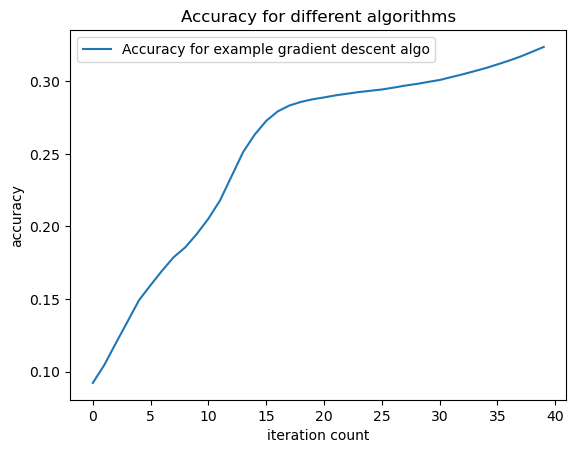

In [9]:
plt.plot(accuracy[0], accuracy[1], label = "Accuracy for example gradient descent algo")
plt.xlabel("iteration count")
plt.ylabel("accuracy")
plt.title("Accuracy for different algorithms")
plt.legend()

## Permutations to test:
### Different Z1 activation functions (and associated derivatives):
- ReLU
- Sigmoid
- arctan
- leaky ReLU
- parametric ReLU
- Exponential LU (ELU)
- Scaled ELU
- Gaussian Error LU (GELU)
- Swish
- Softplus
-
### Different Z2 normalizations:
- numerically stable softmax (what I needed to make it work)
- softmax given in the video didn't work, worth it to test again
- $\frac{Z^2}{\sum Z^2}$ ?
- $\frac{Z - \min(Z)}{\max(Z) - \min(Z)}$ ?
- $\frac{Z - \mu}{\sigma}$ ?
- logsoftmax
- sparsemax
- entmax
### $\alpha$
- 0.1 works fairly well
- see if 0.01 or lower is more stable
- see how high we can push learning rate (0.5)?
-


In [58]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction[0])
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  0
Label:  0


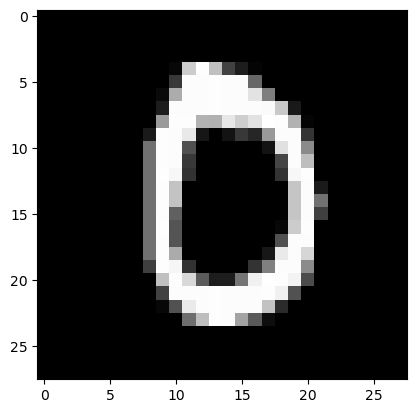

In [66]:
# test_prediction(random.randint(0,m), W1, b1, W2, b2)